In [9]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Imports

In [12]:
import sys
import os
# add library module to PYTHONPATH
sys.path.append(f"{os.getcwd()}/../")

import sklearn
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import xgboost as xgb
from xgboost import plot_importance, plot_tree, plotting

from dtreeviz import trees 
from dtreeviz import treeviz

import graphviz
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

import pandas as pd
import numpy as np
from dtreeviz.models.shadow_decision_tree import ShadowDecTree3
from dtreeviz.models.xgb_decision_tree import XGBDTree
from dtreeviz import treeviz
from dtreeviz import exceptions

In [13]:
pd.options.display.max_rows = 999

# Train

In [14]:
random_state = 1234
dataset = pd.read_csv("../data/titanic/titanic.csv")
# Fill missing values for Age
dataset.fillna({"Age":dataset.Age.mean()}, inplace=True)
# Encode categorical variables
dataset["Sex_label"] = dataset.Sex.astype("category").cat.codes
dataset["Cabin_label"] = dataset.Cabin.astype("category").cat.codes
dataset["Embarked_label"] = dataset.Embarked.astype("category").cat.codes
features = ["Pclass", "Age", "Fare", "Sex_label", "Cabin_label", "Embarked_label"]
target = "Survived"

In [15]:
dtrain = xgb.DMatrix(dataset[features], dataset[target])

In [16]:
params = {"max_depth":2, "eta":0.05, "objective":"binary:logistic", "subsample":1}

In [17]:
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=8)

In [18]:
xgb_model.attr("max_depth")

In [19]:
xgb_model.trees_to_dataframe().query("Tree == 0")

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
0,0,0,0-0,Sex_label,1.0,0-1,0-2,0-1,246.604279,222.75
1,0,1,0-1,Pclass,3.0,0-3,0-4,0-3,60.127525,78.50
2,0,2,0-2,Cabin_label,4.0,0-5,0-6,0-5,29.516968,144.25
3,0,3,0-3,Leaf,NaN,NaN,NaN,NaN,0.087356,42.50
4,0,4,0-4,Leaf,NaN,NaN,NaN,NaN,-0.000000,36.00
5,0,5,0-5,Leaf,NaN,NaN,NaN,NaN,-0.072327,118.25
6,0,6,0-6,Leaf,NaN,NaN,NaN,NaN,-0.012963,26.00


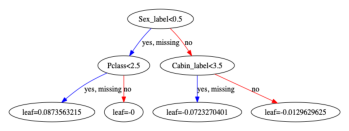

In [20]:
# rcParams['figure.figsize'] = 50,30
plot_tree(xgb_model)

# save the model

In [21]:
import joblib
# joblib.dump(xgb_model, "xgb_model")

# Setup

In [22]:
#dataset[features + [target]].iloc[:20].to_csv("dataset.csv", index=False)


In [23]:
d = dataset[features+ [target]].iloc[:20]
d_matrix = xgb.DMatrix(d)

# Init shadow tree

In [24]:
from dtreeviz.models.xgb_decision_tree import XGBDTree


In [25]:
xgb_shadow = XGBDTree(xgb_model, 1, d[features], d[target], features, target, class_names=[0, 1])

# Parameters meaning
- cover https://stackoverflow.com/questions/33520460/how-is-xgboost-cover-calculated
- https://rdrr.io/cran/xgboost/man/xgb.model.dt.tree.html
- https://eli5.readthedocs.io/en/latest/tutorials/index.html

## left, right children

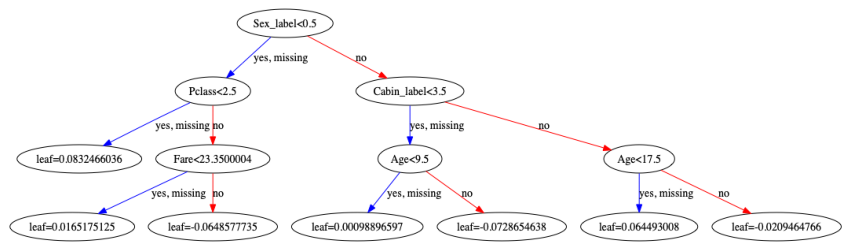

In [187]:
rcParams['figure.figsize'] = 15,10
plot_tree(xgb_model, num_trees=1)

In [188]:
[node.id for node in xgb_shadow.internal]

[4, 1, 5, 6, 2, 0]

In [189]:
[node.id for node in xgb_shadow.leaves]

[3, 7, 8, 9, 10, 11, 12]

## Node split/threshold

In [190]:
??plot_tree

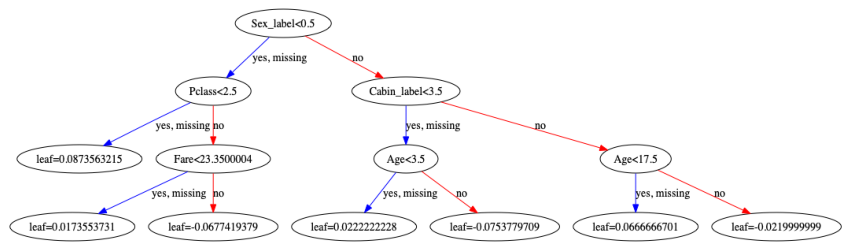

In [191]:
rcParams['figure.figsize'] = 15,10
plot_tree(xgb_model, num_trees=0)

In [192]:
??xgb_model.get_dump

In [193]:
xgb_model.get_dump(dump_format="dot")[1]

'digraph {\n    graph [ rankdir=TB ]\n\n    0 [ label="Sex_label<0.5" ]\n    0 -> 1 [label="yes, missing" color="#0000FF"]\n    0 -> 2 [label="no" color="#FF0000"]\n\n    1 [ label="Pclass<2.5" ]\n    1 -> 3 [label="yes, missing" color="#0000FF"]\n    1 -> 4 [label="no" color="#FF0000"]\n\n    3 [ label="leaf=0.0832466036" ]\n\n    4 [ label="Fare<23.3500004" ]\n    4 -> 7 [label="yes, missing" color="#0000FF"]\n    4 -> 8 [label="no" color="#FF0000"]\n\n    7 [ label="leaf=0.0165175125" ]\n\n    8 [ label="leaf=-0.0648577735" ]\n\n    2 [ label="Cabin_label<3.5" ]\n    2 -> 5 [label="yes, missing" color="#0000FF"]\n    2 -> 6 [label="no" color="#FF0000"]\n\n    5 [ label="Age<9.5" ]\n    5 -> 9 [label="yes, missing" color="#0000FF"]\n    5 -> 10 [label="no" color="#FF0000"]\n\n    9 [ label="leaf=0.00098896597" ]\n\n    10 [ label="leaf=-0.0728654638" ]\n\n    6 [ label="Age<17.5" ]\n    6 -> 11 [label="yes, missing" color="#0000FF"]\n    6 -> 12 [label="no" color="#FF0000"]\n\n    11

In [157]:
xgb_model.trees_to_dataframe().query(f"Tree ==1")

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
13,1,0,1-0,Sex_label,1.00,1-1,1-2,1-1,222.941849,222.490677
14,1,1,1-1,Pclass,3.00,1-3,1-4,1-3,54.640900,78.409081
15,1,2,1-2,Cabin_label,4.00,1-5,1-6,1-5,26.821884,144.081589
16,1,3,1-3,Leaf,NaN,NaN,NaN,NaN,0.083247,42.419022
17,1,4,1-4,Fare,23.35,1-7,1-8,1-7,16.328136,35.990059
18,1,5,1-5,Age,9.50,1-9,1-10,1-9,13.453308,118.086716
19,1,6,1-6,Age,17.50,1-11,1-12,1-11,7.758327,25.994875
20,1,7,1-7,Leaf,NaN,NaN,NaN,NaN,0.016518,29.247799
21,1,8,1-8,Leaf,NaN,NaN,NaN,NaN,-0.064858,6.742262
22,1,9,1-9,Leaf,NaN,NaN,NaN,NaN,0.000989,6.495310


In [159]:
xgb_shadow._get_column_value("Split")

array([ 1.       ,  3.       ,  4.       ,        nan, 23.3500004,
        9.5      , 17.5      ,        nan,        nan,        nan,
              nan,        nan,        nan])

In [161]:
[node.split() for node in xgb_shadow.leaves], [node.split() for node in xgb_shadow.internal]

([-2, -2, -2, -2, -2, -2, -2], [23.3500004, 3.0, 9.5, 17.5, 4.0, 1.0])

In [163]:
xgb_shadow.get_node_split(0)

1.0

## Node feature

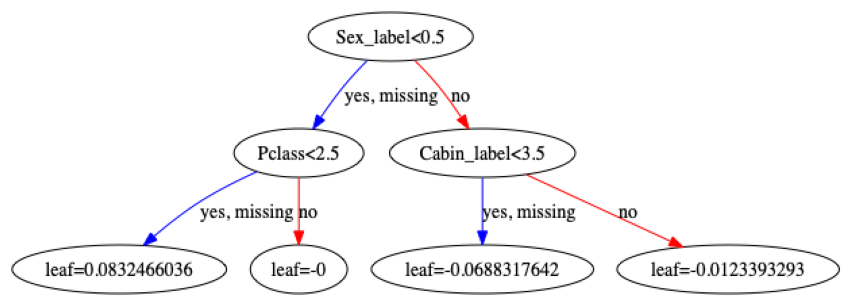

In [20]:
rcParams['figure.figsize'] = 15,10
plot_tree(xgb_model, num_trees=1)

In [165]:
xgb_model.feature_names

['Pclass', 'Age', 'Fare', 'Sex_label', 'Cabin_label', 'Embarked_label']

In [166]:
[(node.id, node.feature()) for node in xgb_shadow.leaves], [(node.id, node.feature()) for node in xgb_shadow.internal]

([(3, -2), (7, -2), (8, -2), (9, -2), (10, -2), (11, -2), (12, -2)],
 [(4, 2), (1, 0), (5, 1), (6, 1), (2, 4), (0, 3)])

## node to samples

In [168]:
xgb_shadow.get_node_samples()

defaultdict(list,
            {10: [0, 4, 5, 12, 13, 17],
             5: [0, 4, 5, 7, 12, 13, 16, 17],
             2: [0, 4, 5, 6, 7, 12, 13, 16, 17],
             0: [0,
              1,
              2,
              3,
              4,
              5,
              6,
              7,
              8,
              9,
              10,
              11,
              12,
              13,
              14,
              15,
              16,
              17,
              18,
              19],
             3: [1, 3, 9, 11, 15],
             1: [1, 2, 3, 8, 9, 10, 11, 14, 15, 18, 19],
             7: [2, 8, 10, 14, 18, 19],
             4: [2, 8, 10, 14, 18, 19],
             12: [6],
             6: [6],
             9: [7, 16]})

In [171]:
xgb_shadow.get_node_samples()[0]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

## Node nsample

In [173]:
[(node.id, node.nsamples()) for node in xgb_shadow.leaves], [(node.id, node.nsamples()) for node in xgb_shadow.internal]


([(3, 5), (7, 6), (8, 0), (9, 2), (10, 6), (11, 0), (12, 1)],
 [(4, 6), (1, 11), (5, 8), (6, 1), (2, 9), (0, 20)])

## n_sample_classes

In [201]:
[node.n_sample_classes() for node in xgb_shadow.leaves]

[[0, 5], [2, 4], [0, 0], [2, 0], [5, 1], [0, 0], [1, 0]]

## is classifier

# Visualisations classifier

## viz_leaf_samples

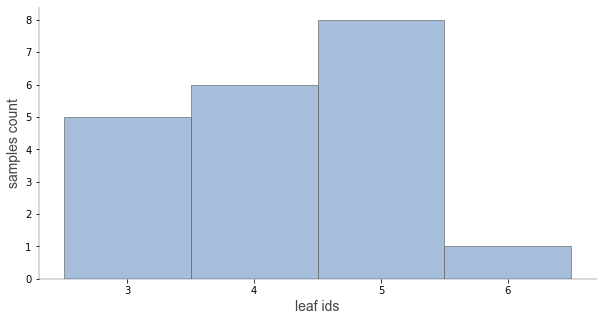

In [28]:
treeviz.viz_leaf_samples(xgb_model, d[features], d[target], features, target, class_names=[0, 1], tree_index=1)

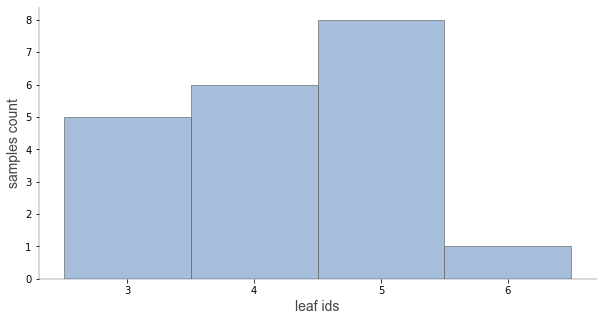

In [46]:
treeviz.viz_leaf_samples(xgb_shadow)

## ctreeviz_leaf_samples

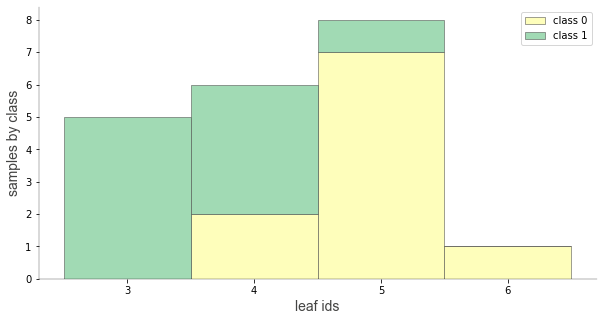

In [48]:
treeviz.ctreeviz_leaf_samples(xgb_model, d[features], d[target], features, target, class_names=[0, 1], tree_index=1  )

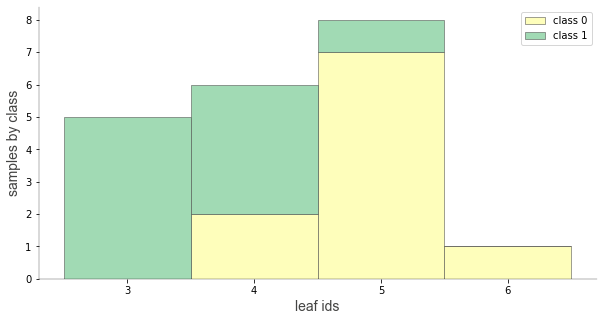

In [47]:
treeviz.ctreeviz_leaf_samples(xgb_shadow)

## dtreeviz

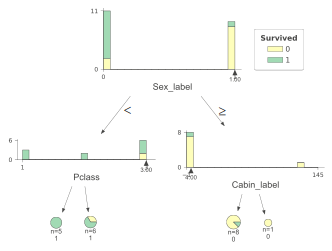

In [50]:
treeviz.dtreeviz(xgb_model, d[features], d[target], features, target, class_names=[0, 1], tree_index=1)

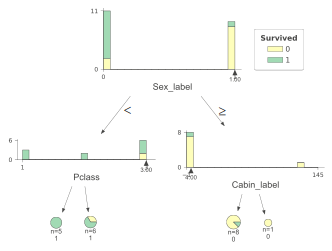

In [49]:
treeviz.dtreeviz(xgb_shadow)

## describe_node_sample

In [54]:
d[features]

,Pclass,Age,Fare,Sex_label,Cabin_label,Embarked_label
0,3,22.000000,7.2500,1,-1,2
1,1,38.000000,71.2833,0,81,0
2,3,26.000000,7.9250,0,-1,2
3,1,35.000000,53.1000,0,55,2
4,3,35.000000,8.0500,1,-1,2
5,3,29.699118,8.4583,1,-1,1
6,1,54.000000,51.8625,1,129,2
7,3,2.000000,21.0750,1,-1,2
8,3,27.000000,11.1333,0,-1,2
9,2,14.000000,30.0708,0,-1,0


In [64]:
treeviz.describe_node_sample(xgb_model, 1, d[features], d[target], features, tree_index=1)

,Pclass,Age,Fare,Sex_label,Cabin_label,Embarked_label
count,11.000000,11.000000,11.000000,11.0,11.000000,11.000000
mean,2.272727,30.154465,24.167418,0.0,29.363636,1.454545
std,0.904534,16.467629,20.603166,0.0,48.512416,0.934199
min,1.000000,4.000000,7.225000,0.0,-1.000000,0.000000
25%,1.500000,20.000000,9.529150,0.0,-1.000000,1.000000
50%,3.000000,29.699118,16.700000,0.0,-1.000000,2.000000
75%,3.000000,36.500000,28.310400,0.0,52.000000,2.000000
max,3.000000,58.000000,71.283300,0.0,145.000000,2.000000


In [51]:
treeviz.describe_node_sample(xgb_shadow, 1)

,Pclass,Age,Fare,Sex_label,Cabin_label,Embarked_label
count,11.000000,11.000000,11.000000,11.0,11.000000,11.000000
mean,2.272727,30.154465,24.167418,0.0,29.363636,1.454545
std,0.904534,16.467629,20.603166,0.0,48.512416,0.934199
min,1.000000,4.000000,7.225000,0.0,-1.000000,0.000000
25%,1.500000,20.000000,9.529150,0.0,-1.000000,1.000000
50%,3.000000,29.699118,16.700000,0.0,-1.000000,2.000000
75%,3.000000,36.500000,28.310400,0.0,52.000000,2.000000
max,3.000000,58.000000,71.283300,0.0,145.000000,2.000000


## explain_prediction_path

In [234]:
dataset[features].iloc[5]

Pclass             3.000000
Age               29.699118
Fare               8.458300
Sex_label          1.000000
Cabin_label       -1.000000
Embarked_label     1.000000
Name: 5, dtype: float64

In [73]:
treeviz.explain_prediction_path(xgb_model, dataset[features].iloc[5], "plain_english", d[features], d[target], features, target, tree_index=1)


1.0 <= Sex_label
Cabin_label < 4.0


In [74]:
treeviz.explain_prediction_path(xgb_shadow, dataset[features].iloc[5], explanation_type="plain_english")

1.0 <= Sex_label
Cabin_label < 4.0


# Visualisations regressor